In [1]:
import sys
import os
import networkx as nx
import matplotlib.pyplot as plt

from powergrid_synth.generator import PowerGridGenerator
from powergrid_synth.input_configurator import InputConfigurator
from powergrid_synth.bus_type_allocator import BusTypeAllocator
from powergrid_synth.capacity_allocator import CapacityAllocator
from powergrid_synth.load_allocator import LoadAllocator
from powergrid_synth.generation_dispatcher import GenerationDispatcher
from powergrid_synth.transmission import TransmissionLineAllocator
from powergrid_synth.visualization import GridVisualizer
from powergrid_synth.exporter import GridExporter

          SYNTHETIC POWER GRID GENERATION DEMO              

[1/8] Configuring Input Parameters...
------------------------------------------------------------
Generating Level 0: DGLN distribution (Avg=3.0)
Generating Level 1: DGLN distribution (Avg=2.2)
Generating Transformers 0<->1: k-Stars Model
4.15
Configuration complete.

[2/8] Generating Grid Topology...
------------------------------------------------------------
--- Starting Generation for 2 Voltage Levels ---
Generating Level 0...
  -> Level 0 Complete. Nodes: 11, Edges: 10
Generating Level 1...
  -> Level 1 Complete. Nodes: 6, Edges: 5
Generating Transformer Connections...
  -> Connecting Level 0 <-> Level 1
Filtering for Largest Connected Component (LCC)...
  -> Kept 10 nodes (removed 7 isolated nodes).
-> Nodes: 10
-> Edges: 10

[3/8] Allocating Bus Types (Gen, Load, Conn)...
------------------------------------------------------------
Starting Bus Type Allocation (N=10, M=10)...
  Target Entropy Score (W*): 2.8146, Std 

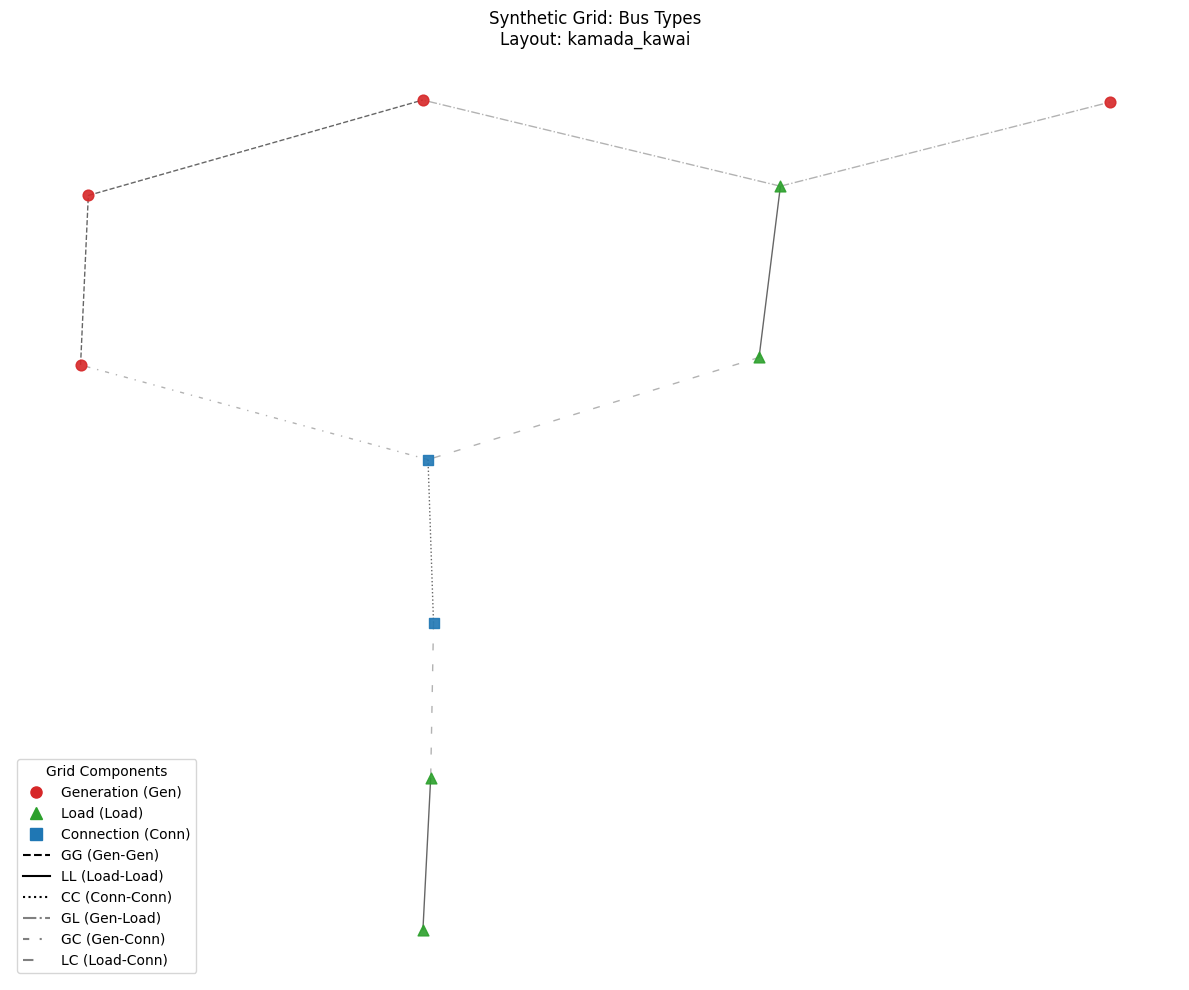

-> Plotting Generation vs Load Bubbles...


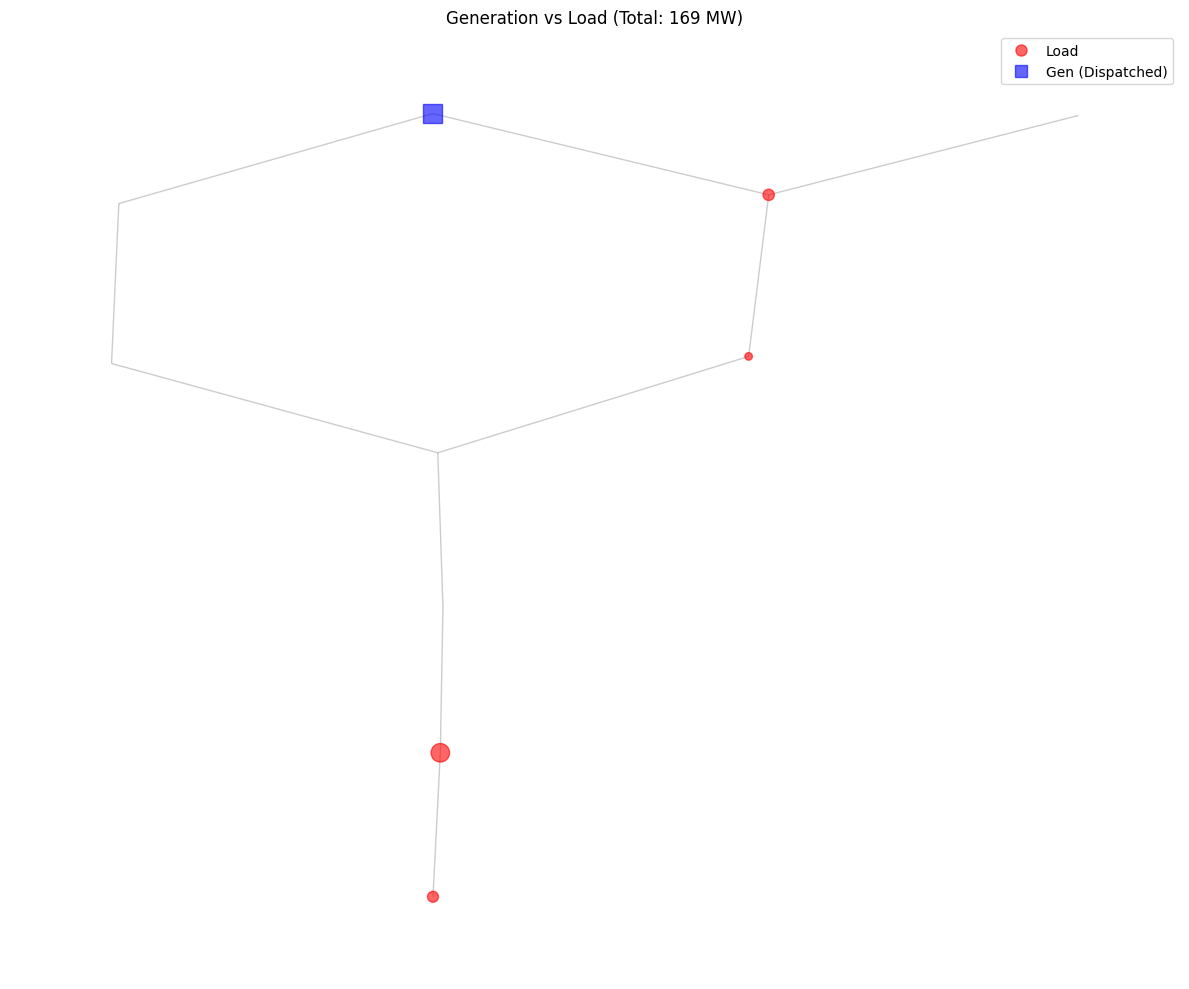

-> Plotting Transmission Line Impedances...


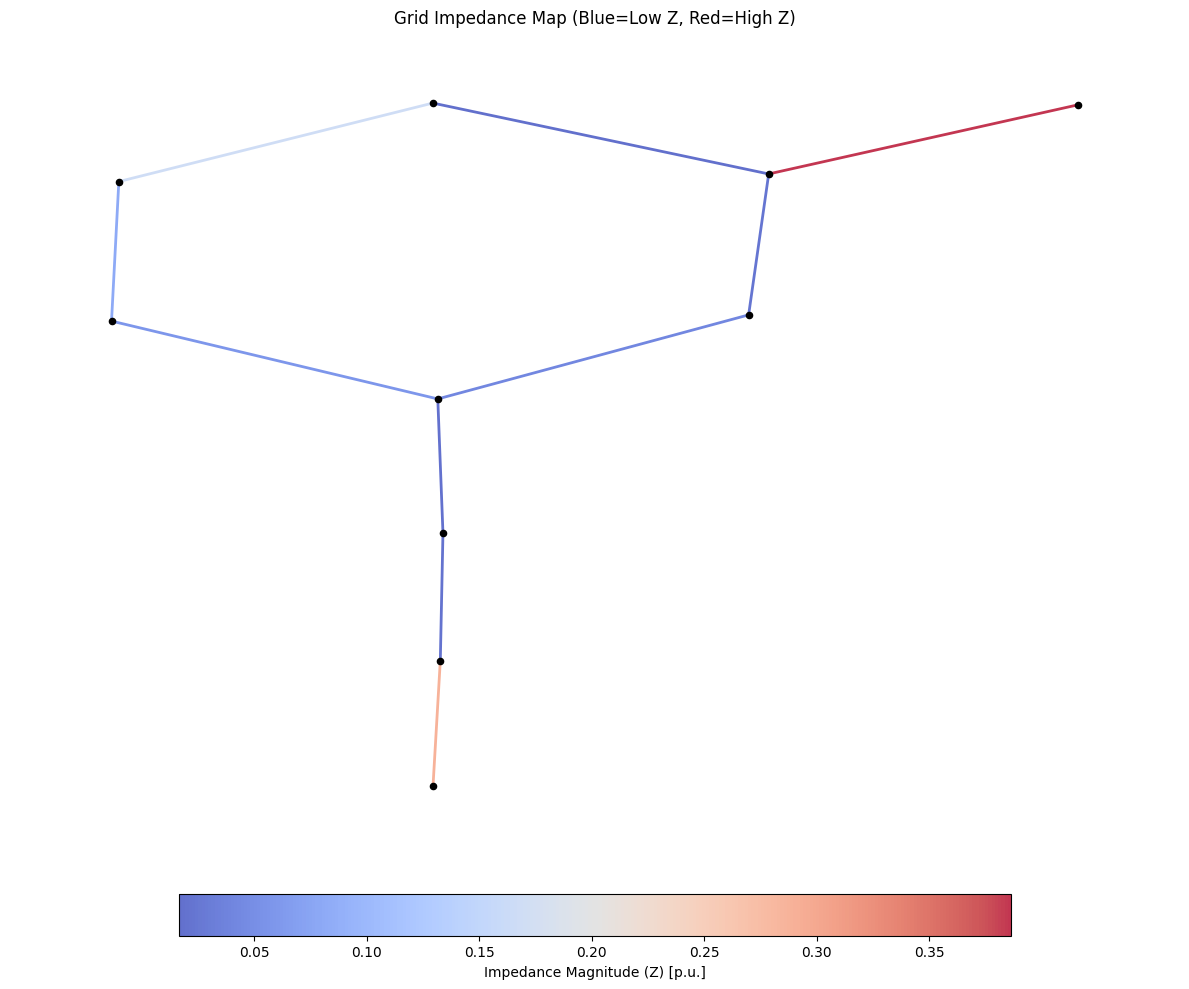


Demo Completed Successfully.
PowerGridGraph with 10 nodes and 10 edges


In [2]:
def print_separator():
    print("-" * 60)
    

print("============================================================")
print("          SYNTHETIC POWER GRID GENERATION DEMO              ")
print("============================================================")

# 1. Configuration
print("\n[1/8] Configuring Input Parameters...")
print_separator()
configurator = InputConfigurator(seed=42)

# Using 'dgln' (Discrete Generalized Log-Normal) for degree distribution
level_specs = [
    {'n': 10, 'avg_k': 3.0, 'diam': 6, 'dist_type': 'dgln'},
    {'n': 5, 'avg_k': 2.2, 'diam': 10, 'dist_type': 'dgln'}
]
connection_specs = { (0, 1): {'type': 'k-stars', 'c': 0.174, 'gamma': 4.15} }
params = configurator.create_params(level_specs, connection_specs)
print("Configuration complete.")

# 2. Topology Generation
print("\n[2/8] Generating Grid Topology...")
print_separator()
gen = PowerGridGenerator(seed=42)
grid = gen.generate_grid(
    params['degrees_by_level'], 
    params['diameters_by_level'], 
    params['transformer_degrees'],
    keep_lcc=True
)
print(f"-> Nodes: {grid.number_of_nodes()}")
print(f"-> Edges: {grid.number_of_edges()}")

# 3. Bus Type Allocation
print("\n[3/8] Allocating Bus Types (Gen, Load, Conn)...")
print_separator()
type_allocator = BusTypeAllocator(grid)
bus_types = type_allocator.allocate(max_iter=20)
nx.set_node_attributes(grid, bus_types, name="bus_type")

# Count types for verification
counts = {}
for t in bus_types.values():
    counts[t] = counts.get(t, 0) + 1
print(f"-> Gens: {counts.get('Gen', 0)}")
print(f"-> Loads: {counts.get('Load', 0)}")
print(f"-> Connections: {counts.get('Conn', 0)}")

# 4. Capacity Allocation
print("\n[4/8] Allocating Generation Capacities (PgMax)...")
print_separator()
cap_allocator = CapacityAllocator(grid, ref_sys_id=1)
capacities = cap_allocator.allocate()
nx.set_node_attributes(grid, capacities, name="pg_max")
total_cap = sum(capacities.values())
print(f"-> Total Generation Capacity: {total_cap:.2f} MW")

# 5. Load Allocation
print("\n[5/8] Allocating Loads (PL)...")
print_separator()
load_allocator = LoadAllocator(grid, ref_sys_id=1)
loads = load_allocator.allocate(loading_level='M')
nx.set_node_attributes(grid, loads, name="pl")
total_load = sum(loads.values())
print(f"-> Total Load Demand: {total_load:.2f} MW")

# 6. Generation Dispatch
print("\n[6/8] Dispatching Generation...")
print_separator()
dispatcher = GenerationDispatcher(grid, ref_sys_id=1)
dispatch = dispatcher.dispatch()
nx.set_node_attributes(grid, dispatch, name="pg")
total_gen = sum(dispatch.values())
print(f"-> Total Power Dispatched: {total_gen:.2f} MW")
print(f"-> Generation Reserve: {total_cap - total_gen:.2f} MW")

# 7. Transmission Line Allocation
print("\n[7/8] Allocating Transmission Lines (Impedance & Capacity)...")
print_separator()
trans_allocator = TransmissionLineAllocator(grid, ref_sys_id=1)
line_caps = trans_allocator.allocate()

total_lines = len(line_caps)
avg_cap = sum(line_caps.values()) / total_lines if total_lines > 0 else 0
print(f"-> Allocated {total_lines} Lines")
print(f"-> Average Line Capacity: {avg_cap:.2f} MVA")

# 8. Visualization
print("\n[8/8] Visualizing Grid...")
print_separator()
viz = GridVisualizer()

print("-> Plotting Bus Types...")
viz.plot_bus_types(grid, layout='kamada_kawai', title="Synthetic Grid: Bus Types", show_impedance=False)

print("-> Plotting Generation vs Load Bubbles...")
viz.plot_load_gen_bubbles(grid, layout='kamada_kawai', title=f"Generation vs Load (Total: {total_load:.0f} MW)")

print("-> Plotting Transmission Line Impedances...")
viz.plot_impedance(grid, layout='kamada_kawai', title="Grid Impedance Map (Blue=Low Z, Red=High Z)")

print("\nDemo Completed Successfully.")
print("============================================================")
print(grid)    


In [3]:
grid.__dict__.keys()

dict_keys(['graph', '_node', '_adj', '__networkx_cache__', 'degree', 'nodes', 'edges', 'adj'])

In [4]:
print("\n[8/9] Exporting Grid Data...")
print_separator()
exporter = GridExporter(grid)

# Export MATPOWER (Supported by Pandapower & Pypowsybl)
export_file = "./synthetic_grid.m"
exporter.export_to_matpower(export_file)
print(f"-> Pypowsybl Bridge: Saved as {export_file}")

# Export CSVs (Good for Pandapower)
csv_folder = "./synthetic_grid_pandapower"
exporter.export_to_pandapower_csv(csv_folder)
print(f"-> Pandapower Bridge: Saved to {csv_folder}/")


[8/9] Exporting Grid Data...
------------------------------------------------------------
-> MATPOWER export success: ./synthetic_grid.m
-> Pypowsybl Bridge: Saved as ./synthetic_grid.m
-> Pandapower CSV export success: ./synthetic_grid_pandapower/
   (Physical units calculated with V_base=230.0kV, S_base=100.0MVA)
-> Pandapower Bridge: Saved to ./synthetic_grid_pandapower/
